To generate slides, execute the following command:

`jupyter nbconvert Projects.ipynb --to slides --no-prompt --TagRemovePreprocessor.remove_input_tags='["remove_cell"]' --SlidesExporter.reveal_theme=simple --post serve`

In [1]:
import numpy as np
from scipy import linalg, signal
from matplotlib import pyplot as plt

rng = np.random.default_rng()

In [2]:
def ceil(a):
    return int(a + 0.5)

In [3]:
# Taken from https://codegolf.stackexchange.com/questions/69993/the-m%C3%B6bius-function
def mobius(n, d=1):
    return d % n and -mobius(d, n % d == 0) + mobius(n, d+1) or 1 // n

In [10]:
def divisors(n):
    return [i for i in range(1, n // 2 + 1) if n % i == 0] + [n]

In [4]:
MINIMUM_N = 2
MINIMUM_D = MINIMUM_N

# MTH 810 Projects
Luke Baumann
April 21st, 2021

*Trying out Jupyter slides. No spell check. Apologies in advance.

## Outline

0. Polynomial Class
1. Sieve of Eratosthenes for Irreducible Polynomials
2. Fast Number Theoretic Transform and Inverse
3. QR Code Overview

## Polynomial Class

Polynomials in $F_{p^\infty}$

Base Implemented Operations
1. `__add__`: Addition
2. `__neg__`: Additive inverse
3. `__lshift__`: Multiplication by x**n
4. `__mul__`: Multiplication by integers and polynomials
5. `__divmod__`: Long Division by integers and polynomials

Derived Operators
1. `__sub__`: Addition + Additive inverse -> Subtraction
2. `__floordiv__`: Quotient -> Long Division
3. `__mod__`: Remainder -> Long Division
4. `__pow__`: Multiplication -> Exponentiation

## Polynomial Class

Because $p$ is prime, for $a \in F_p$, $a^{-i} = a^{p - i - 1}$.

Likewise, if $P(x)$ is an irreducible polynomial, for $a \in F_{p^n} / P(x)$, $a^{-i} = a^{p^n - i - 1}$.

Thus, `__pow__` gives the multiplicative inverse.

Utility
1. `generate_polynomials`: Generates all polynomials up to a give degree
2. `generate_monomials`: Generate all monomials up to a give degree
3. `primitive_element`: Finding primitive element given a characteristic polynomial

In [5]:
class PolynomialNP(object):
    def __init__(self, p, polynomial):
        self.p = p

        if isinstance(polynomial, int):
            degree = polynomial
            polynomial = np.zeros(degree + 1, dtype=np.int64)
        elif isinstance(polynomial, (tuple, list)):
            polynomial = np.array(polynomial)

        if np.any(polynomial > p):
            raise ValueError('polynomial has an entry not in alphabet p', polynomial)
        if not np.issubdtype(polynomial.dtype, np.integer):
            raise ValueError('polynomial coefficients must be of integer type', polynomial.dtype)

        polynomial = np.int64(polynomial.copy())

        self.polynomial = polynomial
        
    @classmethod
    def identity(cls, p):
        return cls(p, np.array([1], dtype=np.int64))
    
    @classmethod
    def zero(cls, p):
        return cls(p, np.array([], dtype=np.int64))

    def __hash__(self):
        """Needed so that polynomials can be put into a set among other things.
        Should not change polynomial after hashing unless you want bad things to happen
        """
        return hash(self.p) ^ hash(tuple(i for i in self.polynomial))
    
    def __eq__(self, other):
        """Needed so that polynomials can be put into a set among other things.
        Should not change polynomial after hashing unless you want bad things to happen
        """
        if not isinstance(other, PolynomialNP):
            return False
        return (self.degree == other.degree) and (self.p == other.p) and np.all(self.polynomial == other.polynomial)

    @property
    def degree(self):
        """The degree of the polynomial is one less than the number of terms"""
        return self.polynomial.size - 1

    def copy(self):
        """Returns a copy of the polynomial"""
        return PolynomialNP(self.p, self.polynomial.copy())
    
    def __add__(self, other):
        """Adds two polynomials together.
        The degree is the max degree of the two polynomials.
        Each term is mod added."""
        if isinstance(other, PolynomialNP):
            if self.p != other.p:
                raise ValueError('Can only add polynomials with the same alphabet', self.p, other.p)

            ret = np.zeros(max(self.degree + 1, other.degree + 1), dtype=np.int64)
            ret[:self.degree + 1] += self.polynomial
            ret[:other.degree + 1] += other.polynomial
            
            ret %= self.p
            
            return PolynomialNP(self.p, np.trim_zeros(ret, 'b'))

        else:
            return NotImplemented

        return ret
    
    def __lshift__(self, other):
        """Multiplies by x**other.
        New degree is old degree + 1 + other"""
        if not isinstance(other, int):
            return NotImplemented

        degree_increase = other
        ret = np.zeros(self.degree + 1 + degree_increase, dtype=np.int64)
        ret[degree_increase:] = self.polynomial

        return PolynomialNP(self.p, ret)
    
    def __mul__(self, other):
        """Multiplies polynomial by an integer or another polynomial.
        If multiplying by an integer, it must be within the alphabet and the
        term-by-term multiplication is mod p.
        If multiplying by a polynomial, multiply and shift the one polynomial
        by each factor and by each order in the other polynomial"""
        if isinstance(other, int):
            factor = other
            ret = self.polynomial * factor
            ret %= self.p

            ret = PolynomialNP(self.p, ret)

        elif isinstance(other, PolynomialNP):
            if self.p != other.p:
                raise ValueError('Can only multiply polynomials with the same alphabet', self.p, other.p)

            ret = np.zeros(self.degree + other.degree + 1, dtype=np.int64)

            outer_product = self.polynomial[:, np.newaxis] * other.polynomial[np.newaxis, :]

            for i in range(self.degree + 1):
                ret[i:i + other.degree + 1] += outer_product[i, :]

            ret = PolynomialNP(self.p, ret % self.p)

        else:
            return NotImplemented
        
        return ret
    
    __rmul__ = __mul__
    
    def __sub__(self, other):
        return self + -other
    
    def __neg__(self):
        return PolynomialNP(self.p, -self.polynomial % self.p)

    def __divmod__(self, other):
        """Calculates the quotient and remainder after division of by other"""
        
        # if dividing by a number, covert it to a polynomial of degree 0 and try again.
        if isinstance(other, int):
            return divmod(self, PolynomialNP(self.p, [other]))
        
        elif isinstance(other, PolynomialNP):
            if self.p != other.p:
                raise ValueError('Can only divmod polynomials with the same alphabet', self.p, other.p)

            # First, we want to multiply the top and bottom by a factor such that we are
            # dividing by a monomial so we find the factor here.
            for factor in range(1, self.p):
                if factor * other.polynomial[-1] % self.p == 1:
                    break
            if factor * other.polynomial[-1] % self.p != 1:
                raise ValueError('Something is wrong. Should have been able to find '
                                 'multiplicative inverse of {}'.format(other.polynomial[-1]))

            # Perform long division
            # We apply the factor at each iteration so that ret is the final remainder instead of
            # factor * remainder, requiring another division to get the remainder.
            ret = self.copy()
            quotient = np.zeros(ret.degree + 1, dtype=np.int64)
            while ret.degree >= other.degree:
                quotient[ret.degree - other.degree] = ret.polynomial[-1] * factor % self.p
                ret -= ret.polynomial[-1] * (factor * other) << ret.degree - other.degree

        else:
            return NotImplemented
        
        return PolynomialNP(self.p, quotient), ret

    def __floordiv__(self, other):
        """Division of a polynomial by other"""
        return divmod(self, other)[0]

    def __mod__(self, other):
        """Modulo of a polynomial by other"""
        return divmod(self, other)[1]
    
    def __pow__(self, other):
        """Raise a polynomial to an integer power"""
        if isinstance(other, int):
            if other < 0:
                raise ValueError('Must raise polynomial to positive power. '
                                'If you are trying to raise a field element '
                                'to a negative power, raise it to p**n - other - 1 '
                                'power instead.')

            ret = PolynomialNP.identity(self.p)
            for i in range(other):
                ret *= self

        else:
            return NotImplemented

        return ret

    def __repr__(self):
        """Represent the polynomial in a string"""
        ret = []
        for i in range(self.degree + 1):
            factor = self.polynomial[i]
            if factor != 0:
                ret += ['{factor}*x**{i}'.format(factor=factor, i=i)]

        if len(ret) == 0:
            return '0'
        else:
            return ' + '.join(reversed(ret))
    
    def __str__(self):
        """Print information about the polynomial and its representation"""
        ret = []
        ret += ['p: {}'.format(self.p)]
        ret += ['Degree: {}'.format(self.degree)]
        ret += [repr(self)]
        return '\n'.join(ret)
    
    @classmethod
    def generate_polynomials(cls, p, N):
        polynomial = np.zeros(N + 1, dtype=np.int64)
        for i in range(p**(N + 1)):
            for j in range(N + 1):
                i, polynomial[j] = divmod(i, p)

            yield cls(p, polynomial)
            
    @classmethod
    def generate_monomials(cls, p, N_min, N_max=None):
        if N_max is None:
            N_min, N_max = 0, N_min

        for n in range(N_min, N_max + 1):
            for i in range(p**n):
                polynomial = np.zeros(n, dtype=np.int64)
                for j in range(n):
                    i, polynomial[j] = divmod(i, p)

                yield (cls.identity(p) << n) + cls(p, polynomial)

    @classmethod
    def primitive_element(cls, p, n, characteristic_poly):
        d = p**n - 1

        for poly in cls.generate_polynomials(p, n):
            if cls.primitive_element_test(poly, p, n, characteristic_poly):
                return poly
        
        raise ValueError('There is always a primitive element if p is prime and the '
                         'characteristic polynomial is irreducible but none were found.')
        
    @classmethod
    def primitive_element_test(cls, poly, p, n, characteristic_poly):
        polys = set()

        for i in range(1, p**n):
            poly_power = poly**i % characteristic_poly

            if poly_power in polys:
                return False

            polys.add(poly_power)

        return len(polys) == p**n - 1

## Sieve of Eratosthenes for Irreducible Polynomials

Rudimentary method to find irreducible polynomials below a certain degree.

### Review: Sieve of Eratosthenes for Prime Numbers

Rudimentary method to find prime numbers below a certain number.

In [6]:
def sieve_of_eratosthenes_primes(N):
    # All positive numbers except 1 which is defined to be not irreducible 
    potential_primes = set(range(2, N + 1))

    for number in range(N):
        if number in potential_primes:
            # Remove all multiples of number
            potential_primes -= set(number * i
                                    for i in range(2, ceil(N / number) + 1))

    return potential_primes

In [7]:
N = 100
print('Primes under {}'.format(N), sieve_of_eratosthenes_primes(100))

Primes under 100 {2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97}


In [8]:
# Used the sieve to find primes. Can be replaced by any function that returns a set of primes
primes = sieve_of_eratosthenes_primes

In [9]:
# Finds the smallest prime divisor under prime_max
def smallest_prime_divisor(x, prime_max=None):
    if prime_max is None:
        prime_max = x

    remainder = None
    for x_1 in primes(prime_max):
        if x_1 > np.sqrt(x) and x_1 != x:
            continue

        x_2, remainder = divmod(x, x_1)
        if remainder == 0:
            break

    if remainder != 0:
        raise ValueError('No prime divisor under {}'.format(prime_max))
        
    return x_1, x_2

### Sieve of Eratosthenes for Irreducible Polynomials
#### Number of Irreducible Polynomials

Can confirm the number of irreducible polynomials by Gauss's formula where $p$ is the dictionary size, $n$ is the degree of the monomial, $D$ is the set of all positive divisors of $n$, and $\mu$ is Möbius number (1 if number of factors if even, otherwise, -1).

$$
I_{p^n} = \sum \limits_{d \in D} \mu \left( n / d \right) p^d
$$

In [11]:
def I_pn(p, n):
    l = [mobius(d)*p**(n // d) for d in divisors(n)]
    return int(sum(l) // n)

In [12]:
def sieve_of_eratosthenes_irreducible_polynomials(p, N):
    # All monomials except 1*x**0 which is defined to be not irreducible 
    potential_irreducible_monomials  = set(PolynomialNP.generate_monomials(p, 1, N))

    for mono in PolynomialNP.generate_monomials(p, N):
        if mono in potential_irreducible_monomials:
            # Remove all multiples of poly
            potential_irreducible_monomials -= set(
                mono * mono_other
                for mono_other in PolynomialNP.generate_monomials(p, 1, N - mono.degree))

    # Place monomials into a dictionary for easy inspection
    ret = {degree: set() for degree in range(1, N + 1)}
    for mono in potential_irreducible_monomials:
        ret[mono.degree].add(mono)
        
    return ret

In [13]:
p = 3
N = 5
irreducible_polynomials = sieve_of_eratosthenes_irreducible_polynomials(p, N)
for n, ip in irreducible_polynomials.items():
    print('Degree', n)
    print('    I_pn:', I_pn(p, n))
    print('    # Found:', len(ip))
    print()
print('Irreducible Polynomials of Degree 2')
print(irreducible_polynomials[2])

Degree 1
    I_pn: 3
    # Found: 3

Degree 2
    I_pn: 3
    # Found: 3

Degree 3
    I_pn: 8
    # Found: 8

Degree 4
    I_pn: 18
    # Found: 18

Degree 5
    I_pn: 48
    # Found: 48

Irreducible Polynomials of Degree 2
{1*x**2 + 1*x**0, 1*x**2 + 1*x**1 + 2*x**0, 1*x**2 + 2*x**1 + 2*x**0}


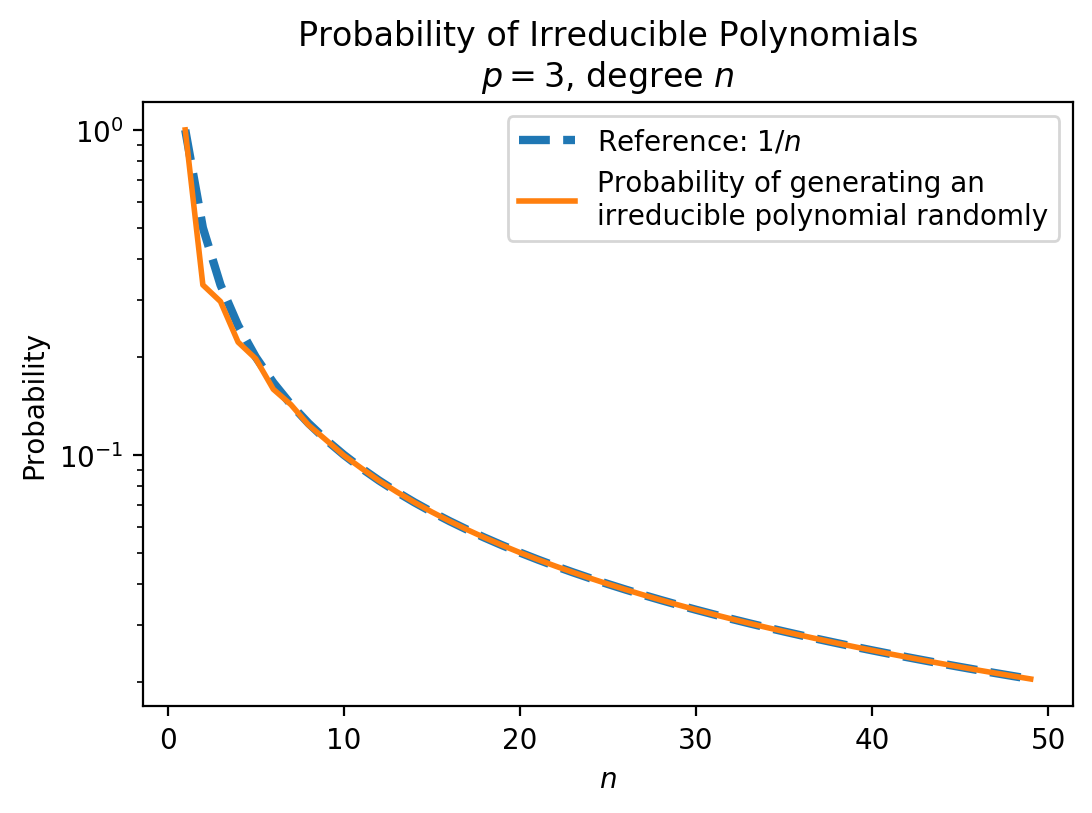

In [14]:
N = 50
p = 3
y_s = []
n_s = np.arange(1, N)
for n in n_s:
    y_s.append(I_pn(p, n) / p**n)
    
plt.figure(dpi=200)
plt.semilogy(n_s, 1 / n_s, lw=3, ls='--', label='Reference: $1/n$')
plt.semilogy(n_s, y_s, lw=2, ls='-', label='\n'.join(['Probability of generating an',
                                                      'irreducible polynomial randomly']))
plt.legend()

plt.xlabel('$n$')
plt.ylabel('Probability')
plt.title('\n'.join(['Probability of Irreducible Polynomials',
                    '$p = {}$, degree $n$'.format(p)]))
plt.show()

## Fast Number Theoretic Transform and Inverse

Fast computation of a transfrom applied to polynomials over a finite field.

### Why Transform

Certain operators and analysis are easier (simpler, faster) to do in a transformed domain than the original domain.

### Review: Discrete Fourier Transforms (DFT)

Invertibly transform a sequence $x_n \in \mathbb{C}$ into another sequence $X_k \in \mathbb{C}$ to perform certain operations easier.

### Incomplete List of Benefits

1. Finite differences become multiplication by $1 - e^{-j 2 \pi k / N}$.
2. Cummulative sums become division by $1 - e^{-j 2 \pi k / N}$.
3. Convolution becomes point-wise multiplication.
4. Harmonic analysis is more natural

### Review: DFT and IDFT

$$
\begin{align}
X_{k} =& \sum \limits _{n=0}^{N-1}x_{n} \left( e^{-j 2\pi /N} \right)^{kn} & X = W^+ x\\
x_{n} =& \frac{1}{K} \sum \limits _{k=0}^{K-1}X_{k} \left( e^{j 2\pi /K} \right)^{nk} & x = \frac{1}{K} W^- X 
\end{align}
$$

Results in a Vandermonde matrix with $\gamma^+ = e^{-j 2\pi / N}$ and $\gamma^- e^{j 2\pi / K}$.

$$W^+=\begin{bmatrix}
1&1&1&1&\cdots &1\\
1&{\gamma^+} &{\gamma^+} ^{2}&{\gamma^+} ^{3}&\cdots &{\gamma^+} ^{N-1}\\1&{\gamma^+}^{2}&{\gamma^+}^{4}&{\gamma^+}^{6}&\cdots &{\gamma^+} ^{(N-1)2}\\1&{\gamma^+} ^{3}&{\gamma^+} ^{6}&{\gamma^+} ^{9}&\cdots &{\gamma^+}^{(N-1)3}\\\vdots &\vdots &\vdots &\vdots &\ddots &\vdots \\1&{\gamma^+} ^{K-1}&{\gamma^+} ^{2(K-1)}&{\gamma^+} ^{3(K-1)}&\cdots &{\gamma^+}^{(N-1)(K-1)}\end{bmatrix}$$

Similar for $W^-$.

### Review: Cooley-Tukey FFT Algorithm

Reexpress DFT of size $N = N_1 N_2$ into $N_1$ DFTs of size $N_2$ recursively, i.e., each DFT of size $N_2 = N_3 N_4$ into $N_3$ DFTs of size $N_4$, etc.

E.g., radix-2 special case where $N_1 = 2$ and $N_2 = N / 2$

$$
X_{k}=\underbrace {\sum \limits _{i=0}^{N_2-1}x_{2n} \left( e^{-j 2\pi / N_2} \right)^{kn}} _{\mathrm {DFT\;of\;even-indexed\;part\;of\;} x_{n}}{} + \left(e^{-j 2 \pi / N} \right)^k \underbrace {\sum \limits _{n=0}^{N_2-1}x_{2n+1} \left( e^{-j 2\pi / N_2} \right)^{kn}} _{\mathrm {DFT\;of\;odd-indexed\;part\;of\;} x_{n}}
$$

$$
\begin{align}
X_{k}=&E_{k}+\left( e^{-j 2\pi / N} \right)^k O_{k}\\
X_{k+N_2}=&E_{k}- \left(e^{-j 2\pi / N} \right)^k O_{k}
\end{align}
$$

Similar for IFFT.

In [15]:
def vander_matmul(w, x):
    N = x.size
    W = np.vander(w, x.size, increasing=True)

    return W @ x

def dft_builtin(x_n):
    N = x_n.size
    return linalg.dft(N) @ x_n

def idft_builtin(X_k):
    N = X_k.size
    return np.conj(linalg.dft(N)) @ X_k / N

def dft(x_n):
    N = x_n.size
    w = np.exp(-1j * 2 * np.pi * np.arange(N) / N)
    return vander_matmul(w, x_n)

def idft(X_k, orig_K=None):
    N = X_k.size
    w = np.exp(1j * 2 * np.pi * np.arange(N) / N)
    
    return vander_matmul(w, X_k) / N

In [16]:
x_n1 = rng.random(20)
X_k = dft(x_n1)
x_n2 = idft(X_k)

print(linalg.norm(x_n1 - x_n2) / linalg.norm(x_n1))

2.1783269226295907e-15


In [17]:
def fft_radix2(x_n):
    """
    Cooley-Tukey Algorithm for Radix-2.
    
    Performs an FFT recusively until the size is no longer a multiple of 2 and then reverts to a DFT.
    """
    N = x_n.size
    if N < MINIMUM_N:
        return dft(x_n)

    # Check to see if N is divisible by 2. If not, perform a DFT
    try:
        N_1, N_2 = smallest_prime_divisor(N, 2)
    except ValueError:
        return dft(x_n)
    
    gamma = np.exp(-1j * 2 * np.pi / N)
    twiddle = gamma**np.arange(N_2)
    
    even = fft_radix2(x_n[::N_1])
    odd = fft_radix2(x_n[1::N_1])

    twiddle_odd = twiddle * odd

    ret = np.zeros(N, dtype=np.complex128)
    ret[:N_2] = even + twiddle_odd
    ret[N_2:] = even - twiddle_odd

    return ret

In [18]:
def ifft_radix2(X_k):
    """
    Cooley-Tukey Algorithm for Radix-2.
    
    Performs an IFFT recusively until the size is no longer a multiple of 2 and then reverts to a IDFT.
    """
    N = X_k.size
    if N < MINIMUM_N:
        return idft(X_k)
    
    # Check to see if K is divisible by 2. If not, perform a IDFT
    try:
        N_1, N_2 = smallest_prime_divisor(N, 2)
    except ValueError:
        return idft(X_k)

    gamma = np.exp(1j * 2 * np.pi / N)
    twiddle = gamma**np.arange(N_2)

    even = ifft_radix2(X_k[::N_1])
    odd = ifft_radix2(X_k[1::N_1])

    twiddle_odd = twiddle * odd

    ret = np.zeros(N, dtype=np.complex128)
    ret[:N_2] = even + twiddle_odd
    ret[N_2:] = even - twiddle_odd

    return ret / N_1

In [19]:
N = 2**10
x_n = rng.random(N)
X_k = fft_radix2(x_n)
x_n1 = ifft_radix2(X_k)

print('FFT Error:', linalg.norm(X_k - np.fft.fft(x_n)) / linalg.norm(np.fft.fft(x_n)))
print('IFFT Error:', linalg.norm(x_n1 - np.fft.ifft(X_k)) / linalg.norm(np.fft.ifft(X_k)))
print('IFFT(FFT(x_n)) Error:', linalg.norm(x_n - x_n1) / linalg.norm(x_n))

FFT Error: 4.201343978483622e-15
IFFT Error: 4.174086104620431e-15
IFFT(FFT(x_n)) Error: 7.020672682930469e-15


### Review: Cooley-Tukey FFT Algorithm

More general case where $N = N_1 N_2$ where $N$ is the number of samples (in both time and frequency) at each level of the recursion.

$$
\begin{align}
X_{k_1 N_2 + k_2}=& \sum \limits_{n_1=0}^{N_1 - 1} \left(e^{-j 2 \pi / N} \right)^{n_1 \left( N_2 k_1 + k_2 \right)} \left( \sum \limits _{n_2=0}^{N_2-1}x_{N_1 n_2 + n_1} \left( e^{-j 2\pi / N_2} \right)^{k_2 n_2} \right) \\
x_{n_1 N_2 + n_2}=& \frac{1}{N_1} \sum \limits_{k_1=0}^{N_1 - 1} \left(e^{j 2 \pi / N} \right)^{k_1 \left( N_2 n_1 + n_2 \right)} \left( \frac{N_1}{N} \sum \limits _{k_2=0}^{N_2-1}X_{N_1 k_2 + k_1} \left( e^{j 2\pi / N_2} \right)^{n_2 k_2} \right)
\end{align}
$$

In [20]:
def fft(x_n):
    N = x_n.size
    if N < MINIMUM_N:
        return dft(x_n)
    
    N_1, N_2 = smallest_prime_divisor(N)

    gamma = np.exp(-1j * 2 * np.pi / N)
    
    parts = [fft(x_n[n_1::N_1]) for n_1 in range(N_1)]
    
    ret = np.zeros(N, dtype=np.complex128)
    for k_1 in range(N_1):
        ret[k_1 * N_2:(k_1 + 1) * N_2] = sum(
            gamma**(n_1 * (N_2 * k_1 + np.arange(N_2))) * part
            for n_1, part in enumerate(parts))

    return ret

In [21]:
def ifft(X_k):
    N = X_k.size
    if N < MINIMUM_N:
        return idft(X_k)
    
    N_1, N_2 = smallest_prime_divisor(N)

    gamma = np.exp(1j * 2 * np.pi / N)
    
    parts = [ifft(X_k[k_1::N_1]) for k_1 in range(N_1)]

    ret = np.zeros(N, dtype=np.complex128)
    for n_1 in range(N_1):
        ret[n_1 * N_2:(n_1 + 1) * N_2] = sum(
            gamma**(k_1 * (N_2 * n_1 + np.arange(N_2))) * part
            for k_1, part in enumerate(parts))

    return ret / N_1

In [22]:
N = 2 * 3 * 5 * 7 * 11
x_n = rng.random(N)
X_k = fft(x_n)
x_n1 = ifft(X_k)

print('FFT Error:', linalg.norm(X_k - np.fft.fft(x_n)) / linalg.norm(np.fft.fft(x_n)))
print('IFFT Error:', linalg.norm(x_n1 - np.fft.ifft(X_k)) / linalg.norm(np.fft.ifft(X_k)))
print('IFFT(FFT(x_n)) Error:', linalg.norm(x_n - x_n1) / linalg.norm(x_n))

FFT Error: 3.632963287721464e-14
IFFT Error: 2.8881688456579974e-14
IFFT(FFT(x_n)) Error: 5.745776431090915e-14


In [23]:
rng = np.random.default_rng()
N = 2**3 * 3 * 5 * 7
print('N', N)
x_n = signal.windows.gaussian(N, N / 10) * np.cos(2 * np.pi / N * N / 12 * np.arange(N))

X_k0 = dft(x_n)
x_n0 = idft(X_k0)

print('Radix-2 FFT')
X_k1 = fft_radix2(x_n)
x_n1 = ifft_radix2(X_k1)
print('    Frequency Domain Error:',
      linalg.norm(X_k1 - X_k0) / linalg.norm(X_k0))
print('    Time Domain Error:',
      linalg.norm(x_n1 - x_n) / linalg.norm(x_n))
print()

print('FFT')
X_k2 = fft(x_n)
x_n2 = ifft(X_k2)
print('    Frequency Domain Error:',
      linalg.norm(X_k1 - X_k0) / linalg.norm(X_k0))
print('    Time Domain Error:',
      linalg.norm(x_n1 - x_n) / linalg.norm(x_n))
print()

print('Numpy')
X_k3 = np.fft.fft(x_n)
x_n3 = np.fft.ifft(X_k3)
print('    Frequency Domain Error:',
      linalg.norm(X_k3 - X_k0) / linalg.norm(X_k0))
print('    Time Domain Error:',
      linalg.norm(x_n3 - x_n) / linalg.norm(x_n))
print()

N 840
Radix-2 FFT
    Frequency Domain Error: 1.2417472992382048e-13
    Time Domain Error: 2.830460714125949e-14

FFT
    Frequency Domain Error: 1.2417472992382048e-13
    Time Domain Error: 2.830460714125949e-14

Numpy
    Frequency Domain Error: 1.2606068718914065e-13
    Time Domain Error: 3.415706460783746e-16



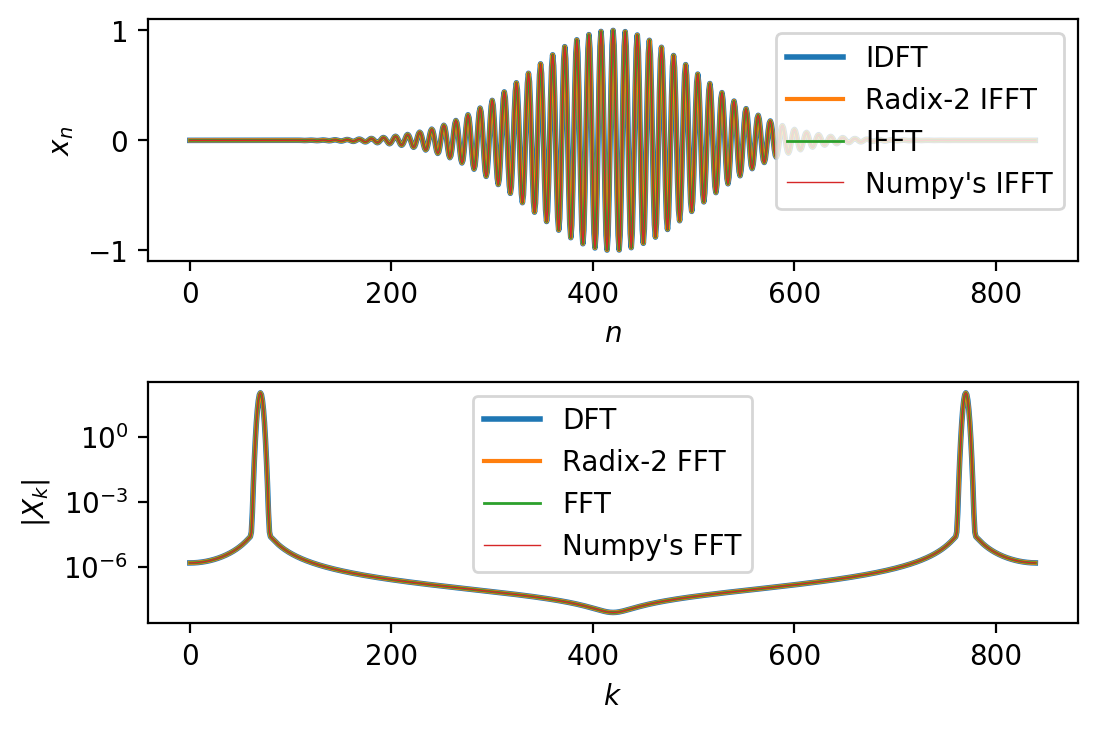

In [24]:
plt.figure(dpi=200)
plt.subplots_adjust(hspace=0.5)
plt.subplot(211)
plt.plot(x_n0.real, lw=2.0, label='IDFT')
plt.plot(x_n1.real, lw=1.5, label='Radix-2 IFFT')
plt.plot(x_n2.real, lw=1.0, label='IFFT')
plt.plot(x_n3.real, lw=0.5, label="Numpy's IFFT")
plt.xlabel('$n$')
plt.ylabel('$x_n$')
plt.legend(loc='upper right')

plt.subplot(212)
plt.semilogy(abs(X_k0), lw=2.0, label='DFT')
plt.semilogy(abs(X_k1), lw=1.5, label='Radix-2 FFT')
plt.semilogy(abs(X_k2), lw=1.0, label='FFT')
plt.semilogy(abs(X_k3), lw=0.5, label="Numpy's FFT")
plt.xlabel('$k$')
plt.ylabel(r'$\left| X_k \right|$')
plt.legend()

plt.show()

### Number Theoretic Transform (NTT)

Invertibly transform a sequence $a_j \in F_{p^n} / P(x)$ (or with slight modification, a ring of integers modulo $p$) into another sequence $A_i \in F_{p^n} / P(x)$ to perform certain operations easier.

### Incomplete List of Benefits

1. Convolution becomes point-wise multiplication.
    1. Multiplication of polynomials over $F_{p^n} / P(x)$
    2. Multiplication of integer polynomials
    3. Multiplication of very large integers
    4. Division of polynomials over $F_{p^n} / P(x)$
2. ***Decoding Reed-Soloman (and Reed-Muller) codes fast because their generator/parity check matrices are Vandermonde matrices of primitive elements.***

### NTT (and INTT) over Finite Fields

1. Field $F_{p^n} / P(x)$ where $p$ is prime and $n \in \mathbb{Z}^+$ and $P(x)$ is an order $n$ irreducible polynomial.
2. Multiplicative group ${F^*}_{p^n} / P(x)$ which is composed of nonzero elements of $F_{p^n} / P(x)$.
3. $d d^\prime = p^n - 1$.
4. $w$ is the primitive element of $F_{p^n} / P(x)$.
5. $a_j$ is a sequence of $d$ elements in $F_{p^n} / P(x)$.
5. $A_i$ is a sequence of $d$ elements in $F_{p^n} / P(x)$.

#### We use the Polynomial class to get elements of $F_{p^n} / P(x)$ by using modulo arithmetic on polynomials.

$$\begin{matrix}
A_i =& \sum \limits _{j = 0}^{d - 1} a_j \left( w^{d^\prime} \right)^{i j} & A = W^+ a & \gamma^+ = w^{d^\prime}\\
a_j =& -d^\prime \sum \limits _{i=0}^{d - 1} A_i \left( w^{-d^\prime} \right)^{j i} & a = -d^\prime W^- A & \gamma^- = w^{-d^\prime}
\end{matrix}$$

### DFT/NTT Comparison

| Discrete Fourier Transform                                                                          | Number Theoretic Transform                                                                          |
|-----------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|
| $x \in \mathbb{C}$                                                                                  | $a \in F_{p^n} / P(x)$                                                                              |
| $X_k = \sum_{n = 0}^{N - 1} x_n \left( e^{-j 2 \pi / N} \right)^{k n}$                              | $A_i = \sum \limits _{j = 0}^{d - 1} a_j \left( w^{d^\prime} \right)^{i j}$                          |
| $x_n = \frac{1}{N} \sum_{k = 0}^{N - 1} X_k \left( e^{j 2 \pi / N} \right)^{n k}$                   | $a_j = -d^\prime \sum \limits _{i = 0}^{d - 1} A_i \left( w^{-d^\prime} \right)^{j i}$              |
| $W^\pm$ is a Vandermonde matrix with $\gamma^+ = e^{-j 2 \pi / N}$ and $\gamma^- = e^{j 2 \pi / N}$ | $W^\pm$ is a Vandermonde matrix with $\gamma^+ = w^{d^\prime}$ and $\gamma^- = w^{-d^\prime}$ |
| $e^{-j 2 \pi / N}$ is the $N$<sup>th</sup> root-of-unity                                            | $w$ is the primitive element of ${F^*}_{p^n} / P(x)$                                                |
| Can be computed fast                                                                                | Can be computed fast                                                                                |

In [25]:
def vander_polynomial(w, characteristic_poly):
    ret = {}
    d = len(w)
    for i in range(d):
        for j in range(d):
            ret[(i, j)] = w[i]**j

    return ret

def vander_polynomial_matmul(p, n, w, characteristic_poly, x_i):
    d = len(x_i)
    W = vander_polynomial(w, characteristic_poly)

    ret = [PolynomialNP(p, n) for _ in range(d)]
    for i in range(d):
        for j in range(d):
            ret[i] += W[(i, j)] * x_i[j]

    for i in range(d):
        ret[i] %= characteristic_poly

    return ret

def ntt(a_j, p, n, characteristic_poly):
    d = len(a_j)
    d_prime, remainder = divmod(p**n - 1, d)
    if remainder != 0:
        raise ValueError('d d_prime must equal p**n - 1')
        
    primitive_element = PolynomialNP.primitive_element(p, n, characteristic_poly)
    r = primitive_element**d_prime
    w = [r**i for i in range(d)]
    
    return vander_polynomial_matmul(p, n, w, characteristic_poly, a_j)

def intt(A_i, p, n, characteristic_poly):
    d = len(A_i)
    d_prime, remainder = divmod(p**n - 1, d)
    if remainder != 0:
        raise ValueError('d d_prime must equal p**n - 1')
        
    primitive_element = PolynomialNP.primitive_element(p, n, characteristic_poly)
    r = primitive_element**(p**n - d_prime - 1)
    w = [r**j for j in range(d)]

    return [-d_prime * a_j
            for a_j in vander_polynomial_matmul(p, n, w, characteristic_poly, A_i)]

### Cooley-Tukey FNTT Algorithm

Skipping the radix-2 specification, the general case is shown with $d = d_1 d_2$ where $d$ is the number of samples (in both domains) at each level of the recursion.

$$
\begin{align}
A_{i_1 d_2 + i_2}=& \sum \limits_{j_1=0}^{d_1 - 1} \left(w^{d^\prime} \right)^{j_1 \left( d_2 i_1 + i_2 \right)} \left( \sum \limits _{j_2=0}^{d_2-1} a_{d_1 j_2 + j_1} \left( w^{d^\prime} \right)^{i_2 j_2} \right) \\
a_{j_1 d_2 + j_2}=& d_1^{-1} \sum \limits_{i_1=0}^{d_1 - 1} \left(w^{-d^\prime} \right)^{i_1 \left( d_2 j_1 + j_2 \right)} \left( -d^\prime d_1 \sum \limits _{i_2=0}^{d_2-1} A_{d_1 i_2 + i_1} \left( w^{-d^\prime} \right)^{j_2 i_2} \right)
\end{align}
$$

## ***THIS IS THE MOST IMPORTANT RESULT FOR THIS WHOLE PROJECT***

In [26]:
p = 3
n = 2

d_prime = 2
d, remainder = divmod(p**n - 1, d_prime)
if remainder != 0:
    raise ValueError('d d_prime must equal p**n - 1')
    
characteristic_poly = PolynomialNP(p, [2, 1, 1])
primitive_element = PolynomialNP.primitive_element(p, n, characteristic_poly)

a_j = [PolynomialNP(p, rng.integers(0, p, n)) for i in range(d)]
A_i = ntt(a_j, p, n, characteristic_poly)
a_j1 = intt(A_i, p, n, characteristic_poly)

print('INTT(NTT) Error:', [aj - aj1 for aj, aj1 in zip(a_j, a_j1)])

INTT(NTT) Error: [0, 0, 0, 0]


In [27]:
def fntt(a_j, p, n, characteristic_polynomial):
    d = len(a_j)
    # Base case, for small d, do naive NTT
    if d < MINIMUM_D:
        return ntt(a_j, p, n, characteristic_polynomial)

    d_prime, remainder = divmod(p**n - 1, d)
    if remainder != 0:
        raise ValueError('d d_prime must equal p**n - 1')

    d_1, d_2 = smallest_prime_divisor(d)

    w = PolynomialNP.primitive_element(p, n, characteristic_poly)
    r = w**d_prime

    parts = [fntt(a_j[j_1::d_1], p, n, characteristic_polynomial)
             for j_1 in range(d_1)]

    A_i = [PolynomialNP(p, n) for i in range(d)]
    for i_1 in range(d_1):
        for i_2 in range(d_2):
            A_i[i_1 * d_2 + i_2] += sum(
                (r**(j_1 * (d_2 * i_1 + i_2)) * part[i_2]
                for j_1, part in enumerate(parts)), PolynomialNP(p, n))

    for i in range(d):
        A_i[i] %= characteristic_poly

    return A_i

In [28]:
def fintt(A_i, p, n, characteristic_polynomial):
    d = len(A_i)
    # Base case, for small d, do naive INTT
    if d < MINIMUM_D:
        return intt(A_i, p, n, characteristic_polynomial)

    d_prime, remainder = divmod(p**n - 1, d)
    if remainder != 0:
        raise ValueError('d d_prime must equal p**n - 1')

    d_1, d_2 = smallest_prime_divisor(d)

    w = PolynomialNP.primitive_element(p, n, characteristic_poly)
    r = w**(p**n - d_prime - 1)

    parts = [fintt(A_i[i_1::d_1], p, n, characteristic_polynomial)
             for i_1 in range(d_1)]

    a_j = [PolynomialNP(p, n) for j in range(d)]
    for j_1 in range(d_1):
        for j_2 in range(d_2):
            a_j[j_1 * d_2 + j_2] += sum(
                (r**(i_1 * (d_2 * j_1 + j_2)) * part[j_2]
                for i_1, part in enumerate(parts)), PolynomialNP(p, n))

    for j in range(d):
        a_j[j] = d_1**(p - 1 - 1) * a_j[j] % characteristic_poly

    return a_j

In [29]:
p = 3
n = 2
d_prime = 2
d, remainder = divmod(p**n - 1, d_prime)
if remainder != 0:
    raise ValueError('d d_prime must equal p**n - 1')
characteristic_poly = PolynomialNP(p, [2, 1, 1])
primitive_element = PolynomialNP.primitive_element(p, n, characteristic_poly)

a_j = [PolynomialNP(p, rng.integers(0, p, n)) for i in range(d)]
A_i = fntt(a_j, p, n, characteristic_poly)
a_j1 = fintt(A_i, p, n, characteristic_poly)

print('FNTT Error:', [Ai - Ai1 for Ai, Ai1 in zip(A_i, ntt(a_j, p, n, characteristic_poly))])
print('FINTT Error:', [aj - aj1 for aj, aj1 in zip(a_j, intt(A_i, p, n, characteristic_poly))])
print('FINTT(FNTT) Error:', [aj - aj1 for aj, aj1 in zip(a_j, a_j1)])

FNTT Error: [0, 0, 0, 0]
FINTT Error: [0, 0, 0, 0]
FINTT(FNTT) Error: [0, 0, 0, 0]


## My Open Questions

1. What is the analog to finite difference? $A_j \left(1 - \left( w^{d^\prime} \right)^j \right)$
2. What is the analog to cummulative sum? $A_j \left(1 - \left( w^{d^\prime} \right)^j \right)^{-1}$
3. What is the analog to harmonic analysis? The interpretation of $A_j$.

## QR Code Overview
Most of this is taken from Wikipedia but a very thorough tutorial is given here: https://www.thonky.com/qr-code-tutorial/

### QR Code key facts

Quick Response Code is 2D barcode (machine-readable, optical label) invented in 1994.

* Micro QR Code sizes: 11x11 to 17x17
* QR Code sizes: 21x21 to 177x177
* Can encode numeric data (0-9), alphanumeric (0-9, a-z, A-Z, " $%*+-./:", byte data, and Kanji characters)
* Four levels of Reed-Solomon error correction (L: 7%, M: 15%, Q: 25%, H: 30%)
* Max Micro QR Code data: 35 numeric, 21 alphanumeric, 15 bytes, 9 Kanji.
* Max QR Code data: 7089 numeric, 4296 alphanumeric, 2953 bytes, 1817 Kanji.
* Reflection, rotation, color inversion independent
* Introduce intentional errors to incorporate colors, logos, art, etc.

![image](images/QRCode-1-Intro.png)

![image](images/QRCode-2-Structure.png)

![image](images/QRCode-3-Layout,Encoding.png)

FYI: QR Codes flip the terminology for blocks and codewords.

The number of erasures and errors that can be corrected is given by $e + 2 t \le d - p$ where $e$ is the number of erasures, $t$ is the number of errors, $d$ is the number of error correcting codewords, and $p$ is the number of misdecode protection codewords.
Not covered in our course, $p$ is the number of extra codewords that can help detect errors but not correct them, $n - k = d + p$.

| Version | Total number<br/>of codewords | Error correction Level      | Number of error<br/>correction codewords | Value of $p$           | Number of error<br/>correction blocks                     | Error correction code</br>per block $(n, k, d)_{2^8}$                                                                                              |
|---------|-------------------------------|-----------------------------|----------------------------------------------------|------------------------|-----------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------|
| M1      | 5                             | Error detection only        | 2                                                  | 2                      | 1                                                         | (5, 3, 0)                                                                                                                                      |
| M4      | 24                            | L<br/> M<br/> Q<br/>        | 8<br/> 10<br/> 14<br/>                             | 2<br/> 0<br/> 0        | 1                                                         | (24, 16, 3)<sup>a</sup><br/> (24, 14, 5)<br/> (24, 10, 7)                                                                                      |
| 1       | 26                            | L<br/> M<br/> Q<br/> H<br/> | 7<br/> 10<br/> 13<br/> 17<br/>                     | 3<br/> 2<br/> 1<br/> 1 | 1                                                         | (26, 19, 2)<sup>a</sup><br/> (26, 16, 4)<sup>a</sup><br/> (26, 13, 6)<sup>a</sup><br/> (26, 9, 8)<sup>a</sup>                                  |
| 10      | 346                           | L<br/> M<br/> Q<br/> H<br/> | 72<br/> 130<br/> 192<br/> 224<br/>                 | 0                      | 2<br/> 2<br/> 4<br/> 1<br/> 6<br/> 2<br/> 6<br/> 2        | (86, 68, 9)<br/> (87, 69, 9)<br/> (69, 43, 13)<br/> (70, 44, 13)<br/> (43, 19, 12)<br/> (44, 20, 12)<br/> (43, 15, 14)<br/> (44, 16, 14)       |
| 20      | 1085                          | L<br/> M<br/> Q<br/> H<br/> | 224<br/> 416<br/> 600<br/> 700<br/>                | 0                      | 3<br/> 5<br/> 3<br/> 13<br/> 15<br/> 5<br/> 15<br/> 10    | (135, 107, 14)<br/> (136, 108, 14)<br/> (67, 41, 13)<br/> (68, 42, 13)<br/> (54, 24, 15)<br/> (55, 25, 15)<br/> (43, 15, 14)<br/> (44, 16, 14) |
| 40      | 3706                          | L<br/> M<br/> Q<br/> H<br/> | 750<br/> 1372<br/> 2040<br/> 2430<br/>             | 0                      | 19<br/> 6<br/> 18<br/> 31<br/> 34<br/> 34<br/> 20<br/> 61 | (148, 118, 15)<br/> (149, 119, 15)<br/> (75, 47, 14)<br/> (76, 48, 14)<br/> (54, 24, 15)<br/> (55, 25, 15)<br/> (45, 15, 15)<br/> (46, 16, 15) |

a: Error correction capacity is less than half the number of error correction codewords to reduce the probability of misdecodes.

![image](images/QRCode-4-Levels,Masks.png)

![image](images/QRCode-5-Protocols.png)

## Thanks!